In [ ]:
# 광원, 측정 스펙트럼으로부터 뇌 내 성분 농도 산출
"""
id : 구분자
rho : 측정 거리 (단위: mm)
src : 광원 스펙트럼 (650 nm ~ 990 nm)
dst : 측정 스펙트럼 (650 nm ~ 990 nm)
hhb : 디옥시헤모글로빈 농도
hbo2 : 옥시헤모글로빈 농도
ca : 칼슘 농도
na : 나트륨 농도
"""

In [1]:
import pandas as pd  
import numpy as np                       
import matplotlib.pyplot as plt            
import seaborn as sns                     
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import missingno as msno

In [2]:
train = pd.read_csv('D:/study/data/train.csv', index_col=0)
test = pd.read_csv('D:/study/data/test.csv', index_col=0)
submission = pd.read_csv('D:/study/data/sample_submission.csv')

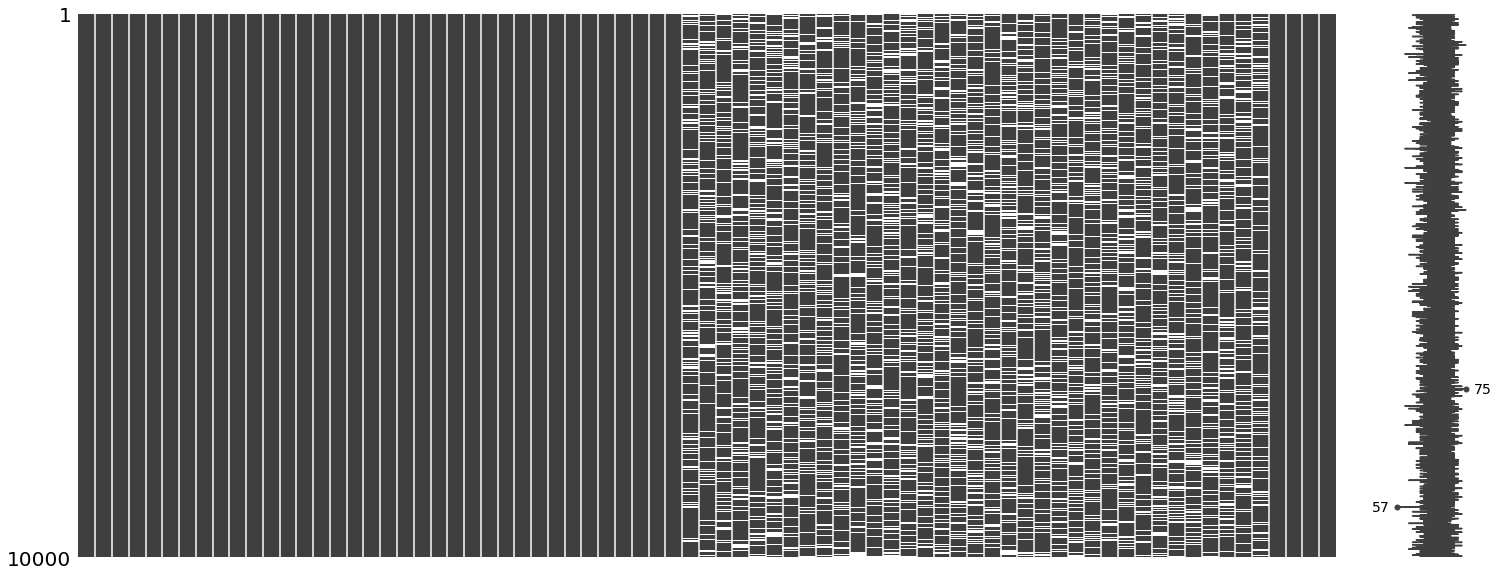

In [3]:
msno.matrix(train)

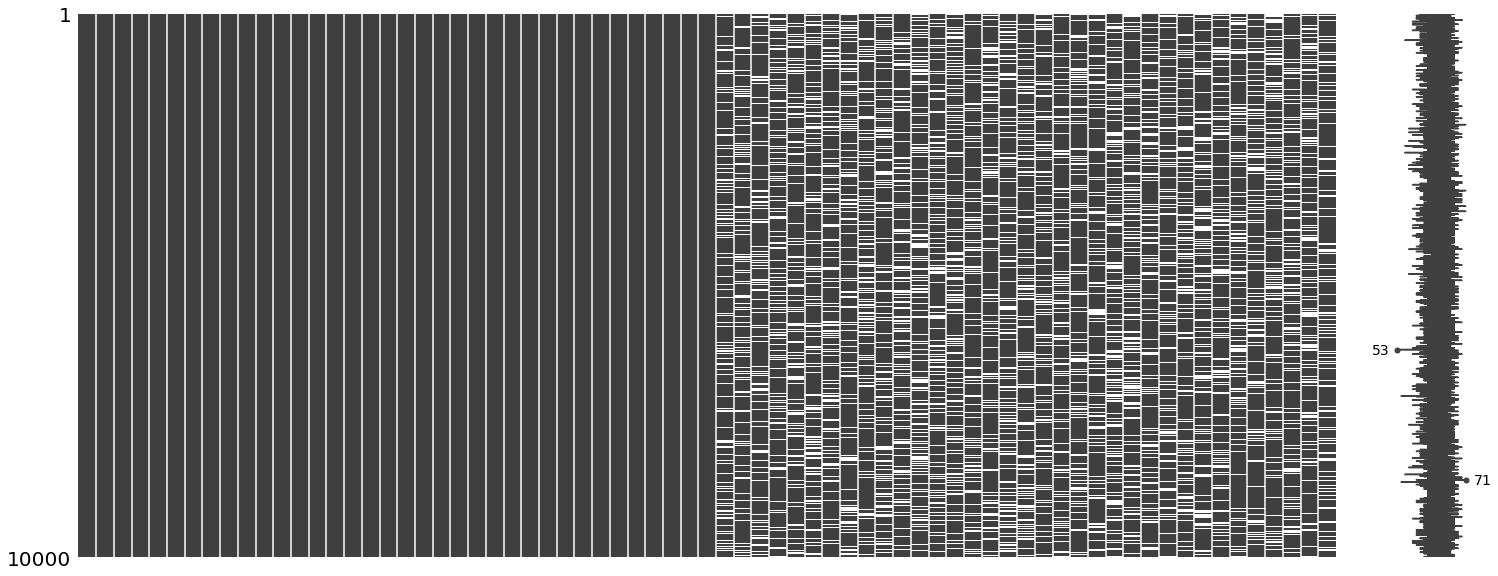

In [4]:
msno.matrix(test)

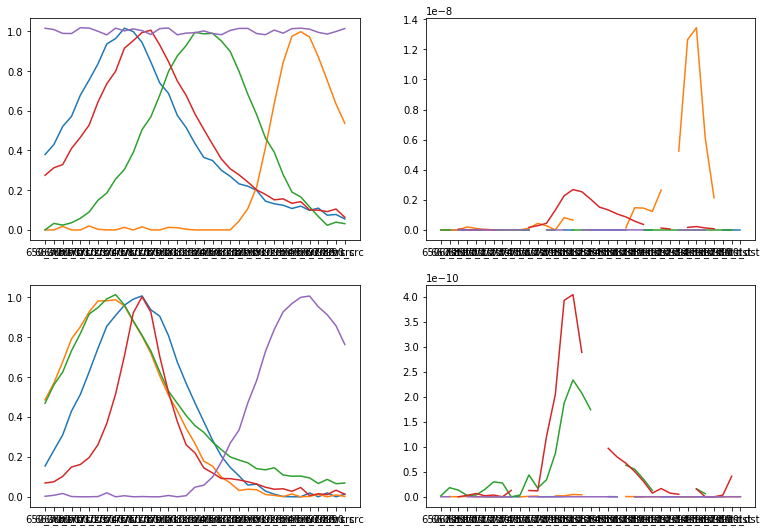

In [7]:
fig = plt.figure(figsize=(13,9))
x1 = fig.add_subplot(2,2,1)
x2 = fig.add_subplot(2,2,2)
x3 = fig.add_subplot(2,2,3)
x4 = fig.add_subplot(2,2,4)
x1.plot(train.filter(regex='_src$',axis=1).head().T) 
x2.plot(train.filter(regex='_dst$',axis=1).head().T) 
x3.plot(test.filter(regex='_src$',axis=1).head().T) 
x4.plot(test.filter(regex='_dst$',axis=1).head().T) 
plt.show()

In [8]:
train_dst = train.filter(regex='_dst$', axis=1).replace(0, np.NaN) # dst 데이터만 따로 뺀다.
test_dst = test.filter(regex='_dst$', axis=1).replace(0, np.NaN) # 보간을 하기위해 결측값을 삭제한다.
# train_dst.head(1)
test_dst.head(1)

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,
10000,NaN,NaN,7.028318e-15,NaN,NaN,2.191340e-14,2.204989e-14,NaN,NaN,1.306867e-15,...,NaN,NaN,1.432248e-14,NaN,NaN,6.332117e-15,1.429966e-14,NaN,NaN,7.320236e-14


In [9]:
train_dst = train_dst.interpolate(methods='linear', axis=1)
test_dst = test_dst.interpolate(methods='linear', axis=1)
# 스팩트럼 데이터에서 보간이 되지 않은 값은 0으로 일괄 처리한다.
train_dst.fillna(0, inplace=True) 
test_dst.fillna(0, inplace=True)
test_dst.head(1)

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,
10000,0.0,0.0,7.028318e-15,1.199001e-14,1.695171e-14,2.191340e-14,2.204989e-14,1.513555e-14,8.221207e-15,1.306867e-15,...,1.808883e-14,1.620565e-14,1.432248e-14,1.165902e-14,8.995570e-15,6.332117e-15,1.429966e-14,3.393389e-14,5.356813e-14,7.320236e-14


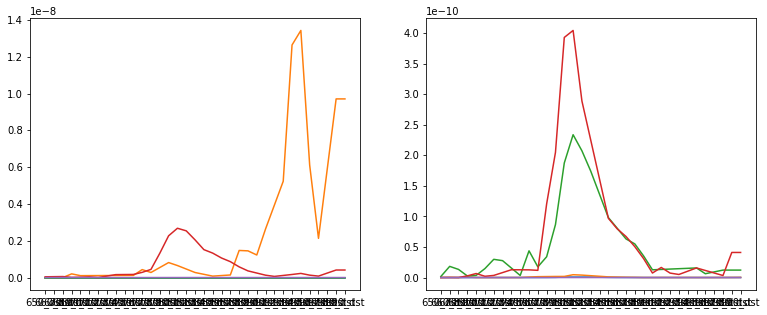

In [12]:
fig = plt.figure(figsize=(13,5))
x1 = fig.add_subplot(1,2,1)
x2 = fig.add_subplot(1,2,2)
x1.plot(train_dst.head().T) 
x2.plot(test_dst.head().T) 
plt.show()

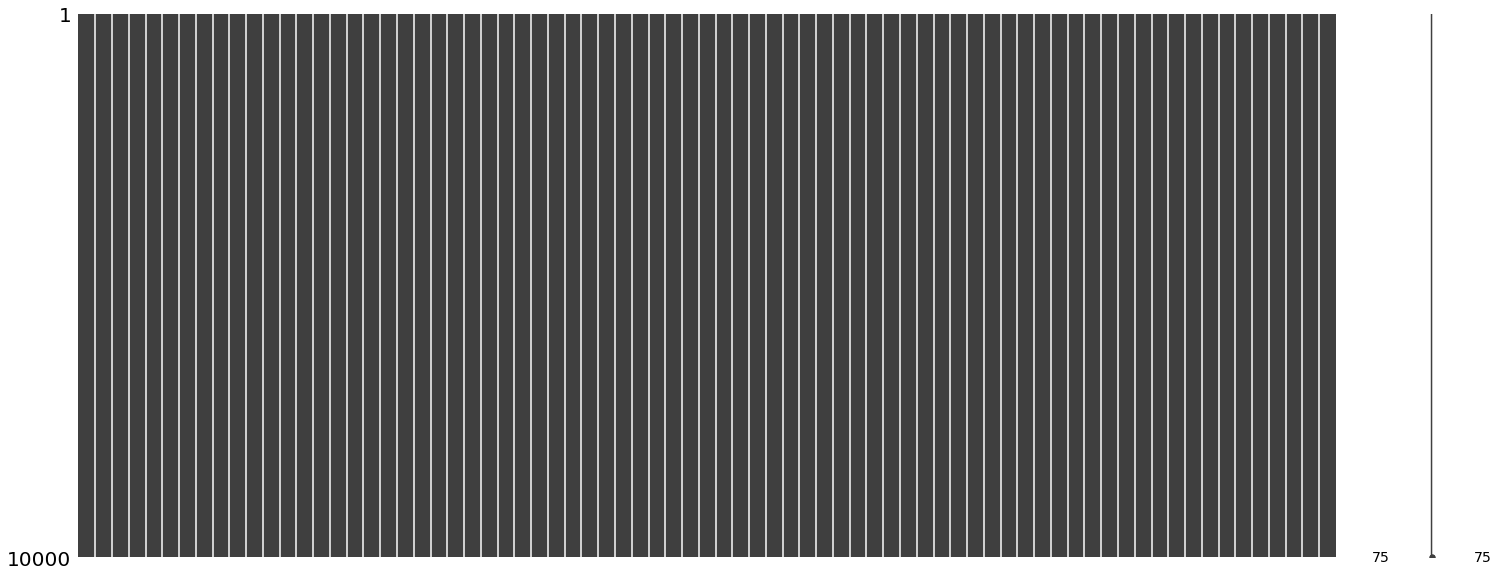

In [13]:
train.update(train_dst) # 보간한 데이터를 기존 데이터프레임에 업데이트 한다.
test.update(test_dst)

msno.matrix(train)

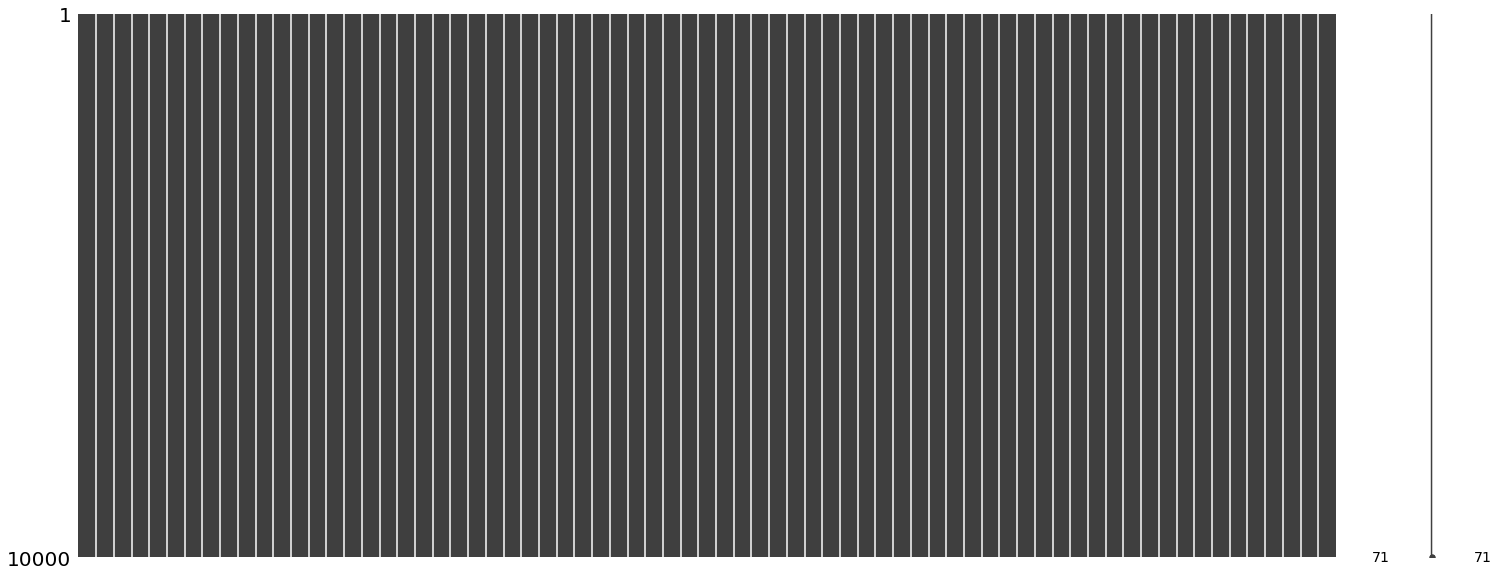

In [14]:
msno.matrix(test)

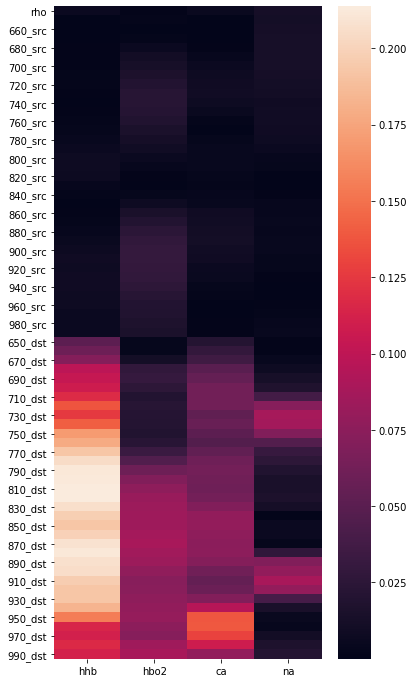

In [15]:
plt.figure(figsize=(6, 12))
sns.heatmap(train.corr().loc['rho':'990_dst', 'hhb':].abs())

In [16]:
x_test = test.loc[:, 'rho':'990_dst']
x_train = train.loc[:, 'rho':'990_dst']
y_train = train.loc[:, 'hhb':'na']
x_train.shape, y_train.shape

((10000, 71), (10000, 4))

In [17]:
## Linear Regression
hhb_model = LinearRegression().fit(x_train, y_train['hhb'])
hbo2_model = LinearRegression().fit(x_train, y_train['hbo2'])
ca_model = LinearRegression().fit(x_train, y_train['ca'])
na_model = LinearRegression().fit(x_train, y_train['na'])

hhb_pred = hhb_model.predict(x_train)
hbo2_pred = hbo2_model.predict(x_train)
ca_pred = ca_model.predict(x_train)
na_pred = na_model.predict(x_train)

preds = pd.DataFrame([hhb_pred,hbo2_pred,ca_pred,na_pred])
lr_preds = preds.T
lr_preds

,0,1,2,3
0,7.619358,3.915040,8.848055,3.063103
1,-5.799930,4.095707,0.151422,8.314792
2,7.716111,3.966047,8.870385,3.119769
3,7.404636,4.005167,8.353698,3.204451
4,8.538321,4.129745,9.351122,3.269244
...,...,...,...,...
9995,8.308621,3.957425,9.344774,3.099550
9996,8.031738,4.078459,9.025760,3.020015
9997,8.342546,4.068216,9.317452,3.058450
9998,8.602941,4.141878,9.551088,3.094092


In [18]:
## Random Forest
hhb_model = RandomForestRegressor().fit(x_train, y_train['hhb'])
hbo2_model = RandomForestRegressor().fit(x_train, y_train['hbo2'])
ca_model = RandomForestRegressor().fit(x_train, y_train['ca'])
na_model = RandomForestRegressor().fit(x_train, y_train['na'])

hhb_pred = hhb_model.predict(x_train)
hbo2_pred = hbo2_model.predict(x_train)
ca_pred = ca_model.predict(x_train)
na_pred = na_model.predict(x_train)

preds = pd.DataFrame([hhb_pred,hbo2_pred,ca_pred,na_pred])
rf_preds = preds.T
rf_preds

,0,1,2,3
0,6.5236,4.0336,8.5046,3.7135
1,3.2055,3.2067,7.8639,3.9819
2,9.5592,3.3086,8.5470,3.8443
3,6.8528,3.7835,6.1430,3.8392
4,10.2646,4.2293,10.3330,2.6943
...,...,...,...,...
9995,11.3402,4.1100,11.0560,1.4962
9996,8.4264,4.2410,9.8013,3.2518
9997,8.9193,3.4520,9.8241,2.5532
9998,6.8687,3.9186,10.1782,3.8717


In [19]:
## XGBoost
hhb_model = XGBRegressor().fit(x_train, y_train['hhb'])
hbo2_model = XGBRegressor().fit(x_train, y_train['hbo2'])
ca_model = XGBRegressor().fit(x_train, y_train['ca'])
na_model = XGBRegressor().fit(x_train, y_train['na'])

hhb_pred = hhb_model.predict(x_train)
hbo2_pred = hbo2_model.predict(x_train)
ca_pred = ca_model.predict(x_train)
na_pred = na_model.predict(x_train)

preds = pd.DataFrame([hhb_pred,hbo2_pred,ca_pred,na_pred])
xgb_preds = preds.T
xgb_preds

,0,1,2,3
0,5.831274,4.169127,8.872152,3.231714
1,0.011159,2.858595,7.281300,4.224067
2,10.375117,3.250119,9.007410,2.903337
3,5.483018,3.787890,6.002171,4.092514
4,11.710239,4.326168,10.357036,2.325062
...,...,...,...,...
9995,12.274143,4.332831,11.546816,2.145851
9996,8.540551,4.504870,9.964710,3.971119
9997,9.980747,3.540800,9.062301,2.686752
9998,6.546626,3.925154,11.047863,4.516742


In [20]:
## mean_absolute_error
print('lr :',mean_absolute_error(y_train,lr_preds))
print('rf :',mean_absolute_error(y_train,rf_preds))
print('xgb :',mean_absolute_error(y_train,xgb_preds))

lr : 1.7090887935707868
rf : 0.6689750774999994
xgb : 0.5446754963876894


In [ ]:
## Best Hyper Parameter
xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=0.3)

# hhb
xgb = XGBRegressor()
params = {'learning_rate':[0.03,0.05,0.07],'max_depth':[6,7,8],'n_estimators':[500,600,700]}
gs = GridSearchCV(xgb,params,cv=5)
eval_set = [(xx_test, yy_test['hhb'])]
model = gs.fit(xx_train,yy_train['hhb'],eval_set=eval_set,eval_metric='mae',verbose=False)
print('hhb :',model.best_params_)

# hbo2
xgb = XGBRegressor()
params = {'learning_rate':[0.03,0.05,0.07],'max_depth':[6,7,8],'n_estimators':[500,600,700]}
gs = GridSearchCV(xgb,params,cv=5)
eval_set = [(xx_test, yy_test['hbo2'])]
model = gs.fit(xx_train,yy_train['hbo2'],eval_set=eval_set,eval_metric='mae',verbose=False)
print('hbo2 :',model.best_params_)

# ca
xgb = XGBRegressor()
params = {'learning_rate':[0.03,0.05,0.07],'max_depth':[6,7,8],'n_estimators':[500,600,700]}
gs = GridSearchCV(xgb,params,cv=5)
eval_set = [(xx_test, yy_test['ca'])]
model = gs.fit(xx_train,yy_train['ca'],eval_set=eval_set,eval_metric='mae',verbose=False)
print('ca :',model.best_params_)

# na
xgb = XGBRegressor()
params = {'learning_rate':[0.03,0.05,0.07],'max_depth':[6,7,8],'n_estimators':[500,600,700]}
gs = GridSearchCV(xgb,params,cv=5)
eval_set = [(xx_test, yy_test['na'])]
model = gs.fit(xx_train,yy_train['na'],eval_set=eval_set,eval_metric='mae',verbose=False)
print('na :',model.best_params_)

In [21]:
## train_test_split
xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=0.3)

hhb_model2 = XGBRegressor(learning_rate=0.04,max_depth=7,n_estimators=500).fit(xx_train, yy_train['hhb'])
hbo2_model2 = XGBRegressor(learning_rate=0.03,max_depth=7,n_estimators=500).fit(xx_train, yy_train['hbo2'])
ca_model2 = XGBRegressor(learning_rate=0.02,max_depth=7, n_estimators=500).fit(xx_train, yy_train['ca'])
na_model2 = XGBRegressor(learning_rate=0.02,max_depth=7, n_estimators=500).fit(xx_train, yy_train['na'])

hhb_pred2 = hhb_model2.predict(xx_test)
hbo2_pred2 = hbo2_model2.predict(xx_test)
ca_pred2 = ca_model2.predict(xx_test)
na_pred2 = na_model2.predict(xx_test)
preds2 = pd.DataFrame([hhb_pred2,hbo2_pred2,ca_pred2,na_pred2])
xgb_preds2 = preds2.T

hhb_pred3 = hhb_model2.predict(xx_train)
hbo2_pred3 = hbo2_model2.predict(xx_train)
ca_pred3 = ca_model2.predict(xx_train)
na_pred3 = na_model2.predict(xx_train)
preds3 = pd.DataFrame([hhb_pred3,hbo2_pred3,ca_pred3,na_pred3])
xgb_preds3 = preds3.T

print('훈련 :',mean_absolute_error(yy_train,xgb_preds3))
print('테스트 :',mean_absolute_error(yy_test,xgb_preds2))
print('hhb :',mean_absolute_error(yy_test['hhb'],hhb_pred2))
print('hbo2 :',mean_absolute_error(yy_test['hbo2'],hbo2_pred2))
print('ca :',mean_absolute_error(yy_test['ca'],ca_pred2))
print('na :',mean_absolute_error(yy_test['na'],na_pred2))

훈련 : 0.6490401029998066
테스트 : 1.222784744342466
hhb : 0.8943315745385487
hbo2 : 0.644579681892395
ca : 2.0144007911141713
na : 1.3378269298247496


In [22]:
## predict
hhb_model = XGBRegressor(learning_rate=0.04,max_depth=7,n_estimators=500).fit(x_train, y_train['hhb'])
hbo2_model = XGBRegressor(learning_rate=0.03,max_depth=7,n_estimators=500).fit(x_train, y_train['hbo2'])
ca_model = XGBRegressor(learning_rate=0.02,max_depth=7,n_estimators=500).fit(x_train, y_train['ca'])
na_model = XGBRegressor(learning_rate=0.02,max_depth=7,n_estimators=500).fit(x_train, y_train['na'])

submission['hhb'] = hhb_model.predict(x_test)
submission['hbo2'] = hbo2_model.predict(x_test)
submission['ca'] = ca_model.predict(x_test)
submission['na'] = na_model.predict(x_test)
submission

,id,hhb,hbo2,ca,na
0,10000,8.901919,4.521845,9.031752,2.951329
1,10001,6.204188,3.653633,9.095451,3.213575
2,10002,10.149492,4.416584,10.511241,3.684608
3,10003,8.624297,4.293617,8.999184,3.427095
4,10004,5.716605,3.810330,8.655601,2.645239
...,...,...,...,...,...
9995,19995,5.141142,3.844895,10.110414,3.593741
9996,19996,11.468199,2.627260,8.532762,2.788754
9997,19997,7.397917,3.440871,8.802352,2.983896
9998,19998,12.581216,4.748760,10.187242,3.485169


In [23]:
## KFold
from sklearn.model_selection import KFold   # K-Fold CV
import xgboost as xgb

def train_model(x_data, y_data, k=5):
    models = []   
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = xgb.DMatrix(data = x_train, label = y_train)
        d_val = xgb.DMatrix(data = x_val, label = y_val)      
        wlist = [(d_train, 'train'), (d_val, 'eval')]
        
        params = {'objective': 'reg:squarederror','eval_metric': 'mae'}
        model = xgb.train(params=params, dtrain=d_train, 
                          num_boost_round=1000, verbose_eval=1000, evals=wlist)
        models.append(model)
    return models

In [24]:
models = {}
for label in y_train.columns:
    print('train column : ', label)
    models[label] = train_model(x_train, y_train[label])
    print('\n')

train column :  hhb
[0]	train-mae:5.29040	eval-mae:5.27296
[999]	train-mae:0.00121	eval-mae:0.96271
[0]	train-mae:5.29984	eval-mae:5.22803
[999]	train-mae:0.00111	eval-mae:0.94714
[0]	train-mae:5.29048	eval-mae:5.29616
[999]	train-mae:0.00107	eval-mae:0.95747
[0]	train-mae:5.28659	eval-mae:5.32278
[999]	train-mae:0.00105	eval-mae:0.95003
[0]	train-mae:5.28244	eval-mae:5.34560
[999]	train-mae:0.00115	eval-mae:0.93651


train column :  hbo2
[0]	train-mae:2.46086	eval-mae:2.47552
[999]	train-mae:0.00095	eval-mae:0.66346
[0]	train-mae:2.46028	eval-mae:2.47928
[999]	train-mae:0.00088	eval-mae:0.64516
[0]	train-mae:2.46841	eval-mae:2.43080
[999]	train-mae:0.00085	eval-mae:0.67626
[0]	train-mae:2.45988	eval-mae:2.47476
[999]	train-mae:0.00088	eval-mae:0.66710
[0]	train-mae:2.46390	eval-mae:2.45637
[999]	train-mae:0.00087	eval-mae:0.68505


train column :  ca
[0]	train-mae:5.99327	eval-mae:6.07837
[999]	train-mae:0.00255	eval-mae:2.15001
[0]	train-mae:6.00224	eval-mae:6.01100
[999]	train-mae:0

In [25]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(xgb.DMatrix(x_test)))
    pred = np.mean(preds, axis=0)
    submission[col] = pred

submission

,id,hhb,hbo2,ca,na
0,10000,8.792499,4.676786,9.197594,3.412182
1,10001,6.922544,3.639186,9.599297,3.772736
2,10002,9.862506,4.666121,11.116873,3.834535
3,10003,8.854456,4.381923,8.709798,3.911726
4,10004,6.121878,3.740761,8.306840,3.256986
...,...,...,...,...,...
9995,19995,4.823951,3.834848,11.052073,4.060177
9996,19996,11.554809,2.510920,8.311505,3.834917
9997,19997,7.104727,3.281137,8.737570,3.936887
9998,19998,12.701578,4.676260,9.709227,3.539157


In [26]:
submission.to_csv('D:/study/Dacon_bio_0530.csv', index=False)